In [114]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 18
%matplotlib inline

# Governing choices for search
N_FOLDS = 10
MAX_EVALS = 10

In [115]:
features = pd.read_csv('train_good.csv')

# Sample 16000 rows (10000 for training, 6000 for testing)
features = features.sample(n = 11900, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['Default'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['Default', 'ID_CPTE'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 3000, random_state = 42)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

train_features.head()

Train shape:  (8900, 60)
Test shape:  (3000, 60)


,fact_CurrentTotalBalance_count,fact_CurrentTotalBalance_mean,fact_CurrentTotalBalance_max,fact_CurrentTotalBalance_min,fact_CurrentTotalBalance_sum,fact_CurrentTotalBalance_skew,fact_CashBalance_count,fact_CashBalance_mean,fact_CashBalance_max,fact_CashBalance_min,...,"('PRIOR_CREDIT_LIMIT_AMT', 'max')","('PRIOR_CREDIT_LIMIT_AMT', 'min')","('PRIOR_CREDIT_LIMIT_AMT', 'sum')","('PRIOR_CREDIT_LIMIT_AMT', 'skew')","('TRANSACTION_AMT', 'count')","('TRANSACTION_AMT', 'mean')","('TRANSACTION_AMT', 'max')","('TRANSACTION_AMT', 'min')","('TRANSACTION_AMT', 'sum')","('TRANSACTION_AMT', 'skew')"
10381,14,1424.866429,3340.54,364.64,19948.13,0.854357,14,0.000000,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4960,14,648.647143,1219.00,54.57,9081.06,-0.361304,14,0.000000,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8163,14,6645.958571,13201.51,2022.48,93043.42,0.607540,14,60.770000,380.10,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7065,14,1194.207143,2013.94,472.94,16718.90,0.339380,14,0.000000,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987,14,849.707143,975.20,562.57,11895.90,-1.504595,14,5.596429,46.35,0.0,...,625.0,22.0,45924.0,1.303881,201.0,27.075622,469.2,0.0,5442.2,4.928984


### Baseline Model

In [116]:
model = lgb.LGBMClassifier(random_state=50)

# Training set
train_set = lgb.Dataset(train_features, label = train_labels)
test_set = lgb.Dataset(test_features, label = test_labels)

In [117]:
# Default hyperparamters
hyperparameters = model.get_params()

# Using early stopping to determine number of estimators.
del hyperparameters['n_estimators']

# Perform cross validation with early stopping
cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 42)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['auc-mean'])))

C:\Users\Daniela\Anaconda3\lib\site-packages\lightgbm\basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


The maximium ROC AUC in cross validation was 0.88698 with std of 0.00852.
The ideal number of iterations was 29.


Now we can evaluate the baseline model on the testing data.

In [118]:
 #Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.88282 ROC AUC on the test set.


### Objective Function

In [119]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Using early stopping to find number of trees trained
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type and subsample to top level keys
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)

    run_time = timer() - start
    
    # Extract the best score
    best_score = cv_results['auc-mean'][-1]
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = len(cv_results['auc-mean'])
    
    # Add the number of estimators to the hyperparameters
    hyperparameters['n_estimators'] = n_estimators

    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

### Domain

Specifying the domain (called the space in Hyperopt) is a little trickier than in grid search. In Hyperopt, and other Bayesian optimization frameworks, the domian is not a discrete grid but instead has probability distributions for each hyperparameter. For each hyperparameter, we will use the same limits as with the grid, but instead of being defined at each point, the domain represents probabilities for each hyperparameter. This will probably become clearer in the code and the images!

In [120]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

In [121]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

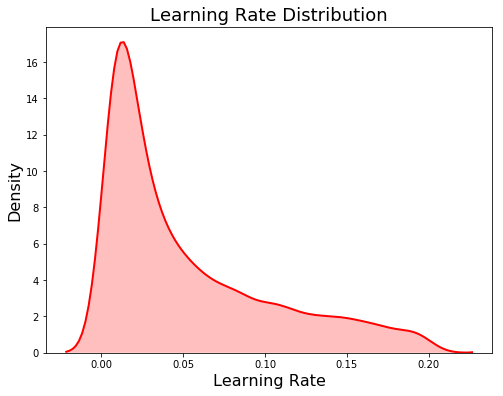

In [122]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(7900):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

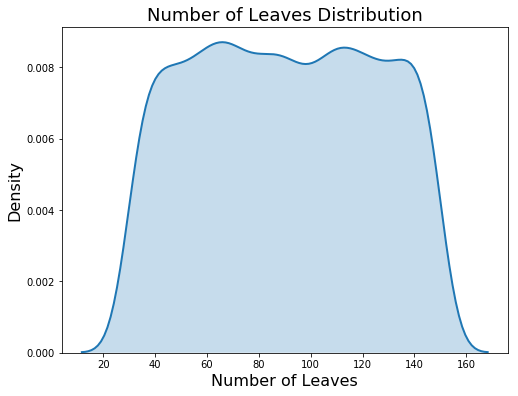

In [123]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(7900):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

Conditional Domain
In Hyperopt, we can use nested conditional statements to indicate hyperparameters that depend on other hyperparameters. For example, the "goss" boosting_type cannot use subsampling, so when we set up the boosting_type categorical variable, we have to set the subsample to 1.0 while for the other boosting types it's a float between 0.5 and 1.0.

In [124]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
hyperparams = sample(boosting_type)
hyperparams

{'boosting_type': {'boosting_type': 'goss', 'subsample': 1.0}}

We need to set both the boosting_type and subsample as top-level keys in the parameter dictionary. We can use the Python dict.get method with a default value of 1.0. This means that if the key is not present in the dictionary, the value returned will be the default (1.0).

In [125]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = hyperparams['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
hyperparams['boosting_type'] = hyperparams['boosting_type']['boosting_type']
hyperparams['subsample'] = subsample

hyperparams

{'boosting_type': 'goss', 'subsample': 1.0}

The gbm cannot use the nested dictionary so we need to set the boosting_type and subsample as top level keys.

Nested conditionals allow us to use a different set of hyperparameters depending on other hyperparameters. For example, we can explore different models with completely different sets of hyperparameters by using nested conditionals. The only requirement is that the first nested statement must be based on a choice hyperparameter (the choice could be the type of model).

### Complete Bayesian Domain

Now we can define the entire domain. Each variable needs to have a label and a few parameters specifying the type and extent of the distribution. For the variables such as boosting type that are categorical, we use the choice variable. Other variables types include quniform, loguniform, and uniform. For the complete list, check out the documentation for Hyperopt. Altogether there are 10 hyperparameters to optimize.

In [126]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

Example of Sampling from the Domain
Let's sample from the domain (using the conditional logic) to see the result of each draw. Every time we run this code, the results will change. (Again notice that we need to assign the top level keys to the keywords understood by the GBM).

In [127]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'goss',
 'colsample_bytree': 0.9252938188014599,
 'is_unbalance': False,
 'learning_rate': 0.03777302613386964,
 'min_child_samples': 200.0,
 'num_leaves': 138.0,
 'reg_alpha': 0.6927228103324505,
 'reg_lambda': 0.18207869731617476,
 'subsample': 1.0,
 'subsample_for_bin': 100000.0}

In [128]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6321276859520862,
 'is_unbalance': False,
 'learning_rate': 0.030957593776215753,
 'min_child_samples': 55.0,
 'num_leaves': 109.0,
 'reg_alpha': 0.5815123237458364,
 'reg_lambda': 0.8183893826118409,
 'subsample': 0.8905510555126552,
 'subsample_for_bin': 200000.0}

Let's test the objective function with the domain to make sure it works. (Every time the of_connection line is run, the outfile will be overwritten, so use a different name for each trial to save the results.)

In [129]:
# Create a new file and open a connection
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# Test the objective function
results = objective(sample(space))
print('The cross validation loss = {:.5f}.'.format(results['loss']))
print('The optimal number of estimators was {}.'.format(results['hyperparameters']['n_estimators']))

The cross validation loss = 0.10722.
The optimal number of estimators was 329.


### Optimization Algorithm

The optimization algorithm is the method for constructing the surrogate function (probability model) and selecting the next set of hyperparameters to evaluate in the objective function. Hyperopt has two choices: random search and Tree Parzen Estimator.

The technical details of TPE can be found in this article and a conceptual explanation is in this article. Although this is the most technical part of Bayesian hyperparameter optimization, defining the algorithm in Hyperopt is simple.

In [130]:
from hyperopt import Trials

# Record results
trials = Trials()

The Trials object will hold everything returned from the objective function in the .results attribute. We can use this after the search is complete to inspect the results, but an easier method is to read in the csv file because that will already be in a dataframe.

In [131]:
# Create a file and open a connection
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

### Automated Hyperparameter Optimization in Practice

We have all four parts we need to run the optimization. To run Bayesian optimization we use the fmin function (a good reminder that we need a metric to minimize!)

In [132]:
from hyperopt import fmin, tpe, hp

fmin takes the four parts defined above as well as the maximum number of iterations max_evals.

In [133]:
# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

best

{'boosting_type': 1,
 'colsample_by_tree': 0.991304678949413,
 'dart_subsample': 0.8090820541658564,
 'is_unbalance': 1,
 'learning_rate': 0.03756977692658773,
 'min_child_samples': 350.0,
 'num_leaves': 67.0,
 'reg_alpha': 0.5073057282312433,
 'reg_lambda': 0.3338005245605391,
 'subsample_for_bin': 260000.0}

In [138]:
results = pd.read_csv(OUT_FILE)

The function below takes in the results, trains a model on the training data, and evalutes on the testing data. It returns a dataframe of hyperparameters from the search.

Saving the results to a csv file converts the dictionary of hyperparameters to a string. We need to map this back to a dictionary using ast.literal_eval.

In [135]:
import ast

def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
    
    new_results = results.copy()
    # String to dictionary
    new_results['hyperparameters'] = new_results['hyperparameters'].map(ast.literal_eval)
    
    # Sort with best values on top
    new_results = new_results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, new_results.loc[0, 'score'], new_results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = new_results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Train and make predictions
    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(new_results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(new_results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = new_results['iteration']
    hyp_df['score'] = new_results['score']
    
    return hyp_df

In [136]:
bayes_results = evaluate(results, name = 'Bayesian')
bayes_results

The highest cross validation score from Bayesian was 0.89217 found on iteration 4.
ROC AUC from Bayesian on test data = 0.89041.


,boosting_type,colsample_bytree,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,metric,verbose,n_estimators,iteration,score
0,dart,0.991305,False,0.037570,350,67,0.507306,0.333801,260000,0.809082,auc,1,618,4,0.892166
1,dart,0.751996,True,0.068830,415,51,0.990971,0.414021,120000,0.684527,auc,1,413,5,0.891511
2,dart,0.658184,False,0.022836,110,49,0.534057,0.702573,180000,0.985067,auc,1,441,8,0.891016
3,gbdt,0.818157,False,0.108565,455,47,0.347243,0.171773,220000,0.582428,auc,1,89,1,0.890348
4,gbdt,0.843663,True,0.055458,145,137,0.230731,0.511729,100000,0.718266,auc,1,52,6,0.889579
5,dart,0.625506,True,0.057830,20,61,0.205188,0.532582,200000,0.821439,auc,1,167,2,0.888192
6,goss,0.722398,True,0.150741,95,85,0.665232,0.560429,40000,1.000000,auc,1,6,10,0.885587
7,goss,0.993068,True,0.162786,280,35,0.471720,0.023881,280000,1.000000,auc,1,6,9,0.879790
8,goss,0.809665,False,0.085799,460,54,0.285526,0.593218,40000,1.000000,auc,1,11,3,0.875136
9,goss,0.659665,True,0.344239,455,126,0.286126,0.054387,200000,1.000000,auc,1,2,7,0.869787


In [ ]:
 MAX_EVALS = 5

# # Create a new file and open a connection
OUT_FILE = 'bayesian_trials_500.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

# # Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# # Record results
trials = Trials()

global ITERATION

ITERATION = 0 

best = fmin(fn = objective, space = space, algo = tpe.suggest,
             trials = trials, max_evals = MAX_EVALS)

# # Sort the trials with lowest loss (highest AUC) first
trials_dict = sorted(trials.results, key = lambda x: x['loss'])

print('Finished, best results')
print(trials_dict[:1])

# # Save the trial results
with open('trials500.json', 'w') as f:
    f.write(json.dumps(trials_dict))

In [139]:
import json

# Save the trial results
with open('trials500.json', 'w') as f:
    f.write(json.dumps(trials_dict))

In [140]:
# Read in full dataset
train = pd.read_csv('train_good.csv')
test = pd.read_csv('test_good.csv')
train = train.drop(columns = ['AssessmentPeriod'])
test = test.drop(columns = ['AssessmentPeriod'])
# Extract the test ids and train labels
test_ids = test['ID_CPTE']
train_labels = np.array(train['Default'].astype(np.int32)).reshape((-1, ))

train = train.drop(columns = ['ID_CPTE', 'Default'])
test = test.drop(columns = ['ID_CPTE'])

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (11900, 60)
Testing shape:  (5100, 60)


In [141]:
bayes_results = pd.read_csv('bayesian_trials_500.csv').sort_values('score', ascending = False).reset_index()

In [142]:
bayes_params = evaluate(bayes_results, name = 'Bayesian')

The highest cross validation score from Bayesian was 0.89275 found on iteration 96.


LightGBMError: b'len of label is not same with #data'

In [143]:
scores = scores.append(pd.DataFrame({'ROC AUC': bayes_params['score'], 'iteration': bayes_params['iteration'], 'search': 'Bayesian'}))

NameError: name 'scores' is not defined

In [144]:
bayes_results['hyperparameters'] = bayes_results['hyperparameters'].map(ast.literal_eval)

In [145]:
hyperparameters = dict(**bayes_results.loc[0, 'hyperparameters'])
del hyperparameters['n_estimators']

# Cross validation with n_folds and early stopping
cv_results = lgb.cv(hyperparameters, train_set,
                    num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS)

print('The cross validation score on the full dataset for Bayesian optimization = {:.5f} with std: {:.5f}.'.format(
    cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('Number of estimators = {}.'.format(len(cv_results['auc-mean'])))

The cross validation score on the full dataset for Bayesian optimization = 0.89275 with std: 0.00842.
Number of estimators = 507.


In [146]:
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), **hyperparameters)
model.fit(train, train_labels)

preds = model.predict_proba(test)[:, 1]

submission = pd.DataFrame({'ID_CPTE': test_ids, 'Default': preds})
submission.to_csv('submission_bayesian_optimization.csv', index = False)

In [147]:
import xgboost as xgb
hyperparameters = dict(**bayes_results.loc[0, 'hyperparameters'])
del hyperparameters['n_estimators']

# Cross validation with n_folds and early stopping
cv_results = xgb.cv(hyperparameters, train_set,
                    num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS)

print('The cross validation score on the full dataset for Bayesian optimization = {:.5f} with std: {:.5f}.'.format(
    cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('Number of estimators = {}.'.format(len(cv_results['auc-mean'])))

AttributeError: 'Dataset' object has no attribute 'num_row'

In [148]:
model_xgb = xgb.XGBClassifier(n_estimators = len(cv_results['auc-mean']), **hyperparameters)
model_xgb.fit(train, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='dart',
       colsample_bylevel=1, colsample_bytree=0.6251259427191308, gamma=0,
       is_unbalance=False, learning_rate=0.03946831148853219,
       max_delta_step=0, max_depth=3, metric='auc', min_child_samples=305,
       min_child_weight=1, missing=None, n_estimators=507, n_jobs=1,
       nthread=None, num_leaves=144, objective='binary:logistic',
       random_state=0, reg_alpha=0.5358601896438846,
       reg_lambda=0.4362156206217483, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7593033982702072, subsample_for_bin=260000,
       verbose=1)

In [149]:
preds = model_xgb.predict_proba(test)[:, 1]

submission = pd.DataFrame({'ID_CPTE': test_ids, 'Default': preds})
submission.to_csv('submission_bayesian_optimizatio3.csv', index = False)

ValueError: feature_names mismatch: ['fact_CurrentTotalBalance_count', 'fact_CurrentTotalBalance_mean', 'fact_CurrentTotalBalance_max', 'fact_CurrentTotalBalance_min', 'fact_CurrentTotalBalance_sum', 'fact_CurrentTotalBalance_skew', 'fact_CashBalance_count', 'fact_CashBalance_mean', 'fact_CashBalance_max', 'fact_CashBalance_min', 'fact_CashBalance_sum', 'fact_CashBalance_skew', 'fact_CreditLimit_count', 'fact_CreditLimit_mean', 'fact_CreditLimit_max', 'fact_CreditLimit_min', 'fact_CreditLimit_sum', 'fact_CreditLimit_skew', 'fact_DelqCycle_count', 'fact_DelqCycle_mean', 'fact_DelqCycle_max', 'fact_DelqCycle_min', 'fact_DelqCycle_sum', 'fact_DelqCycle_skew', 'fact_Owning_count', 'fact_Owning_mean', 'fact_Owning_max', 'fact_Owning_min', 'fact_Owning_sum', 'fact_Owning_skew', 'fact_CreditLeft_count', 'fact_CreditLeft_mean', 'fact_CreditLeft_max', 'fact_CreditLeft_min', 'fact_CreditLeft_sum', 'fact_CreditLeft_skew', 'fact_CashRatio_count', 'fact_CashRatio_mean', 'fact_CashRatio_max', 'fact_CashRatio_min', 'fact_CashRatio_sum', 'fact_CashRatio_skew', "('AmountPaid', 'count')", "('AmountPaid', 'mean')", "('AmountPaid', 'max')", "('AmountPaid', 'min')", "('AmountPaid', 'sum')", "('AmountPaid', 'skew')", "('PRIOR_CREDIT_LIMIT_AMT', 'count')", "('PRIOR_CREDIT_LIMIT_AMT', 'mean')", "('PRIOR_CREDIT_LIMIT_AMT', 'max')", "('PRIOR_CREDIT_LIMIT_AMT', 'min')", "('PRIOR_CREDIT_LIMIT_AMT', 'sum')", "('PRIOR_CREDIT_LIMIT_AMT', 'skew')", "('TRANSACTION_AMT', 'count')", "('TRANSACTION_AMT', 'mean')", "('TRANSACTION_AMT', 'max')", "('TRANSACTION_AMT', 'min')", "('TRANSACTION_AMT', 'sum')", "('TRANSACTION_AMT', 'skew')"] ["('CurrentTotalBalance', 'count')", "('CurrentTotalBalance', 'mean')", "('CurrentTotalBalance', 'max')", "('CurrentTotalBalance', 'min')", "('CurrentTotalBalance', 'sum')", "('CurrentTotalBalance', 'skew')", "('CashBalance', 'count')", "('CashBalance', 'mean')", "('CashBalance', 'max')", "('CashBalance', 'min')", "('CashBalance', 'sum')", "('CashBalance', 'skew')", "('CreditLimit', 'count')", "('CreditLimit', 'mean')", "('CreditLimit', 'max')", "('CreditLimit', 'min')", "('CreditLimit', 'sum')", "('CreditLimit', 'skew')", "('DelqCycle', 'count')", "('DelqCycle', 'mean')", "('DelqCycle', 'max')", "('DelqCycle', 'min')", "('DelqCycle', 'sum')", "('DelqCycle', 'skew')", "('Owning', 'count')", "('Owning', 'mean')", "('Owning', 'max')", "('Owning', 'min')", "('Owning', 'sum')", "('Owning', 'skew')", "('CreditLeft', 'count')", "('CreditLeft', 'mean')", "('CreditLeft', 'max')", "('CreditLeft', 'min')", "('CreditLeft', 'sum')", "('CreditLeft', 'skew')", "('CashRatio', 'count')", "('CashRatio', 'mean')", "('CashRatio', 'max')", "('CashRatio', 'min')", "('CashRatio', 'sum')", "('CashRatio', 'skew')", "('AmountPaid', 'count')", "('AmountPaid', 'mean')", "('AmountPaid', 'max')", "('AmountPaid', 'min')", "('AmountPaid', 'sum')", "('AmountPaid', 'skew')", "('PRIOR_CREDIT_LIMIT_AMT', 'count')", "('PRIOR_CREDIT_LIMIT_AMT', 'mean')", "('PRIOR_CREDIT_LIMIT_AMT', 'max')", "('PRIOR_CREDIT_LIMIT_AMT', 'min')", "('PRIOR_CREDIT_LIMIT_AMT', 'sum')", "('PRIOR_CREDIT_LIMIT_AMT', 'skew')", "('TRANSACTION_AMT', 'count')", "('TRANSACTION_AMT', 'mean')", "('TRANSACTION_AMT', 'max')", "('TRANSACTION_AMT', 'min')", "('TRANSACTION_AMT', 'sum')", "('TRANSACTION_AMT', 'skew')"]
expected fact_CashBalance_min, fact_CashRatio_max, fact_CreditLimit_max, fact_DelqCycle_mean, fact_CreditLeft_max, fact_Owning_min, fact_CurrentTotalBalance_max, fact_CreditLimit_sum, fact_CashBalance_skew, fact_CurrentTotalBalance_min, fact_CreditLeft_skew, fact_CashBalance_sum, fact_CurrentTotalBalance_count, fact_CreditLimit_skew, fact_CreditLeft_mean, fact_CashBalance_count, fact_CurrentTotalBalance_mean, fact_CreditLimit_min, fact_DelqCycle_skew, fact_CashRatio_skew, fact_DelqCycle_min, fact_CashBalance_mean, fact_Owning_skew, fact_CreditLimit_mean, fact_CreditLeft_count, fact_CreditLeft_sum, fact_Owning_max, fact_CashRatio_sum, fact_DelqCycle_sum, fact_CreditLimit_count, fact_CurrentTotalBalance_skew, fact_DelqCycle_max, fact_CurrentTotalBalance_sum, fact_Owning_count, fact_CashRatio_mean, fact_CashBalance_max, fact_Owning_sum, fact_CashRatio_count, fact_CreditLeft_min, fact_CashRatio_min, fact_DelqCycle_count, fact_Owning_mean in input data
training data did not have the following fields: ('CreditLimit', 'min'), ('CashBalance', 'max'), ('CurrentTotalBalance', 'sum'), ('CurrentTotalBalance', 'mean'), ('CreditLeft', 'skew'), ('CashRatio', 'skew'), ('CreditLimit', 'skew'), ('CurrentTotalBalance', 'min'), ('DelqCycle', 'mean'), ('CashRatio', 'max'), ('CashRatio', 'mean'), ('Owning', 'count'), ('Owning', 'mean'), ('CashRatio', 'sum'), ('DelqCycle', 'count'), ('DelqCycle', 'skew'), ('DelqCycle', 'max'), ('CashBalance', 'count'), ('CreditLeft', 'mean'), ('Owning', 'sum'), ('CurrentTotalBalance', 'skew'), ('CashBalance', 'mean'), ('CreditLimit', 'mean'), ('CurrentTotalBalance', 'count'), ('CashRatio', 'count'), ('CreditLimit', 'sum'), ('CreditLeft', 'count'), ('CashBalance', 'skew'), ('CashBalance', 'min'), ('CreditLeft', 'sum'), ('Owning', 'min'), ('DelqCycle', 'sum'), ('CreditLeft', 'min'), ('CashRatio', 'min'), ('Owning', 'max'), ('Owning', 'skew'), ('CreditLeft', 'max'), ('CashBalance', 'sum'), ('CreditLimit', 'count'), ('DelqCycle', 'min'), ('CurrentTotalBalance', 'max'), ('CreditLimit', 'max')